In [1]:
import pandas as pd
import numpy as np
import json
from itertools import chain

import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns

import time
import glob


params = {
   'axes.labelsize': 14,
   'font.size': 14,
   'legend.fontsize': 14,
   'xtick.labelsize': 14,
   'ytick.labelsize': 14,
   'text.usetex': False,
   'figure.figsize': [4.5, 4.5],
    'savefig.facecolor':'white'
   }

mpl.rcParams.update(params)


import random 
random.seed(12357)
np.random.seed(12357)


import pprint 
ppdict = pprint.PrettyPrinter(indent=4, sort_dicts=False)


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score


timestr = time.strftime("%Y%m%d%H%M")
print(timestr) 

202310301520


In [2]:
sol_saveat_dt = [1,1e-4][0]

print(sol_saveat_dt)

inpath = "output/"
outpath = "figures/fig3/" 

1


In [3]:
##############################################
# set to True to save fig

savefigures = True #False #True 

##############################################

In [4]:
! ls -lh output | grep "_u\." | grep "sim_" | wc -l

190


In [5]:
print(len(glob.glob(inpath+"*_u.csv"))) 

190


In [6]:
input_file_ids = [i.rstrip("_u.csv") for i in glob.glob(inpath+"*_u.csv")]


input_file_ids = sorted(input_file_ids)

In [7]:
input_dfs = []

for fid in input_file_ids:

    dfn = fid + "_u.csv"
    tfn = fid + "_t.csv"
    nfn = fid + "_unames.csv"
    
    df = pd.read_csv(dfn,header=None)
    tf = pd.read_csv(tfn,header=None)
    nf = pd.read_csv(nfn,header=None)
    
    df.columns = [i[:-1] for i in nf[0].values.tolist() ]
    
    df['time_s'] = tf[0].copy()
    df['condition'] = fid.replace("output/sim_","").split("_extraTag",1)[0]
    
    input_dfs.append(df)
    
input_df = pd.concat(input_dfs, axis=0, ignore_index=True)

In [8]:
print(input_df.shape)

(58900, 185)


In [9]:
input_df = input_df.reindex(sorted(input_df.columns), axis=1)

In [10]:
input_df = input_df.loc[input_df['time_s']>180,:]
input_df = input_df.reset_index(drop=True)

In [11]:
input_df.head(3)

,ADP_a,ADP_i_a,ADP_i_n,ADP_mi_a,ADP_mi_n,ADP_mx_a,ADP_mx_n,ADP_n,ADPmito_a,ADPmito_n,...,f26bp_a,h,hIP3Ca_a,mGluRboundRatio_a,n,nBK_a,pgate,sTRP_a,time_s,vV
0,0.045,0.045969,0.057954,0.045225,0.056787,1.152120,1.131716,0.047784,1.759665,1.856772,...,0.012238,0.991528,0.653282,0.0,0.021990,0.000007,0.023936,0.001238,181.0,0.0237
1,0.045,0.045971,0.057954,0.045227,0.056787,1.152133,1.131715,0.047784,1.759688,1.856772,...,0.012238,0.991528,0.653285,0.0,0.021989,0.000007,0.023936,0.001238,182.0,0.0237
2,0.045,0.045973,0.057954,0.045230,0.056787,1.152145,1.131715,0.047784,1.759712,1.856771,...,0.012239,0.991528,0.653289,0.0,0.021989,0.000007,0.023936,0.001238,183.0,0.0237


In [12]:
all_cnds_l = sorted(input_df['condition'].unique())
len(all_cnds_l)

190

In [13]:
sel_cnds = ["121_default","g1_61_def"]

In [14]:
sel_mets = [i[0:-1] for i in [     
                    "Glc_t_t0", "Glc_ecsBA0", "Glc_a0", "Glc_ecsAN0", "Glc_n0", "FBP_n0", "FBP_a0", "DHAP_n0", "DHAP_a0","GAP_n0", "GAP_a0", "Lac_b0", "Lac_ecs0", "Lac_a0", "Lac_n0",
    "FUMmito_n0", "MALmito_n0", "OXAmito_n0", "SUCmito_n0", "SUCCOAmito_n0", "CoAmito_n0", 
            "AKGmito_n0",  "ISOCITmito_n0", "CITmito_n0", "AcCoAmito_n0",  "PYRmito_n0",  
    "FUMmito_a0", "MALmito_a0", "OXAmito_a0", "SUCmito_a0", "SUCCOAmito_a0", "CoAmito_a0", 
            "AKGmito_a0", "ISOCITmito_a0", "CITmito_a0", "AcCoAmito_a0", "PYRmito_a0"
    
]]


anaplerotics = [i[0:-1] for i in [  "FUMmito_n0", "MALmito_n0", "OXAmito_n0", "SUCmito_n0", "SUCCOAmito_n0", "CoAmito_n0", 
            "AKGmito_n0",  "ISOCITmito_n0", "CITmito_n0", "AcCoAmito_n0",  "PYRmito_n0",  
    "FUMmito_a0", "MALmito_a0", "OXAmito_a0", "SUCmito_a0", "SUCCOAmito_a0", "CoAmito_a0", 
            "AKGmito_a0", "ISOCITmito_a0", "CITmito_a0", "AcCoAmito_a0", "PYRmito_a0"
        ]]
        
jay_selected = [i[0:-1] for i in ["AKGmito_n0","AKGmito_a0",  "OXAmito_n0","OXAmito_a0", "SUCCOAmito_n0","SUCCOAmito_a0", "FUMmito_n0","FUMmito_a0"]]

print(len(sel_mets))

37


In [15]:
input_df_mp = input_df.loc[input_df['condition'].isin(sel_cnds),sel_mets + ['condition', 'time_s']].copy()  

In [16]:
input_df_mpl = pd.melt(input_df_mp,id_vars=['condition','time_s'])


In [17]:
input_df_mpl.head(3)

,condition,time_s,variable,value
0,121_default,181.0,Glc_t_t,1.399852
1,121_default,182.0,Glc_t_t,1.399846
2,121_default,183.0,Glc_t_t,1.399840


In [18]:
input_df_mpl['log_conc'] = np.log(input_df_mpl['value'])

In [19]:
lut_cnds = {'121_default':"#069e1d", 
                'g1_61_def':"#fa6f0c"
               }


In [20]:
tmp = pd.DataFrame(input_df_mpl.loc[input_df_mpl['variable'].isin(sel_mets),['variable','value','condition']].groupby(['variable','condition']).apply(np.median))

tmp = tmp.sort_values(by=0)

In [21]:
tmp = tmp.reset_index(drop=False)

In [22]:
tmp

,variable,condition,0
0,GAP_n,g1_61_def,0.001215
1,GAP_n,121_default,0.001230
2,SUCCOAmito_a,g1_61_def,0.001675
3,SUCCOAmito_a,121_default,0.001684
4,GAP_a,g1_61_def,0.001815
...,...,...,...
69,Glc_t_t,g1_61_def,0.943114
70,Glc_ecsAN,121_default,1.001148
71,Glc_a,121_default,1.219554
72,Glc_ecsBA,121_default,1.298903


In [23]:
range1 = [i for i in tmp.loc[tmp[0]<0.005,'variable'].unique()  if not i in  anaplerotics]
len(range1)

4

In [24]:
range2 = [i for i in tmp.loc[(tmp[0]>=0.005) & (tmp[0]<0.5),'variable'].unique()  if not i in  anaplerotics]
len(range2)

2

In [25]:
range3 = [i for i in tmp.loc[(tmp[0]>=0.5) & (tmp[0]<1),'variable'].unique() if not i in anaplerotics + ['Glc_n', 'Glc_ecsAN','Glc_a', 'Glc_ecsBA','Glc_t_t']]
len(range3)

4

In [26]:
range4 = ['Glc_n', 'Glc_ecsAN','Glc_a', 'Glc_ecsBA','Glc_t_t'] #tmp.loc[(tmp[0]>=1) ,'variable'].unique()
len(range4)

5

In [27]:
range1j = sorted([i for i in tmp.loc[tmp[0]<0.012,'variable'].unique()  if  i in  jay_selected])
len(range1j)

4

In [28]:
range2j = sorted([i for i in tmp.loc[tmp[0]>=0.012,'variable'].unique()  if  i in  jay_selected])
len(range2j)

4

In [29]:
tmp.loc[tmp['variable'].isin(range1j)]

,variable,condition,0
2,SUCCOAmito_a,g1_61_def,0.001675
3,SUCCOAmito_a,121_default,0.001684
9,SUCCOAmito_n,g1_61_def,0.002565
11,SUCCOAmito_n,121_default,0.002669
18,OXAmito_a,g1_61_def,0.004460
19,OXAmito_a,121_default,0.004532
22,OXAmito_n,g1_61_def,0.011016
23,OXAmito_n,121_default,0.011122


In [30]:
tmp.loc[tmp['variable'].isin(range2j)]

,variable,condition,0
26,AKGmito_a,121_default,0.014752
27,AKGmito_a,g1_61_def,0.014951
38,FUMmito_a,g1_61_def,0.049835
39,FUMmito_a,121_default,0.050373
40,AKGmito_n,g1_61_def,0.067736
41,FUMmito_n,g1_61_def,0.069111
42,FUMmito_n,121_default,0.069525
43,AKGmito_n,121_default,0.071883


In [31]:
range1a = sorted([i for i in tmp.loc[tmp[0]<0.05,'variable'].unique() if (i in anaplerotics) and (i not in jay_selected) ])
len(range1a)

8

In [32]:
range2a = sorted([i for i in tmp.loc[(tmp[0]>=0.05),'variable'].unique() if (i in anaplerotics) and (i not in jay_selected)  and (i not in range1a)])
len(range2a)

6

In [33]:
tmp.loc[tmp['variable'].isin(range1a)]

,variable,condition,0
6,CoAmito_a,g1_61_def,0.002495
7,CoAmito_a,121_default,0.002532
8,CoAmito_n,g1_61_def,0.002562
10,CoAmito_n,121_default,0.002613
16,AcCoAmito_a,121_default,0.004306
17,AcCoAmito_a,g1_61_def,0.004354
24,PYRmito_a,121_default,0.013180
25,PYRmito_a,g1_61_def,0.013314
30,ISOCITmito_n,121_default,0.033115
31,ISOCITmito_n,g1_61_def,0.033120


In [34]:
tmp.loc[tmp['variable'].isin(range2a)]

,variable,condition,0
44,MALmito_a,g1_61_def,0.257336
45,MALmito_a,121_default,0.260312
46,CITmito_n,g1_61_def,0.341266
47,CITmito_n,121_default,0.341310
48,CITmito_a,121_default,0.359859
49,CITmito_a,g1_61_def,0.359894
50,SUCmito_n,121_default,0.370445
51,SUCmito_n,g1_61_def,0.374446
52,MALmito_n,g1_61_def,0.381224
53,MALmito_n,121_default,0.383448


In [ ]:
pd.set_option('display.max_rows', 500)

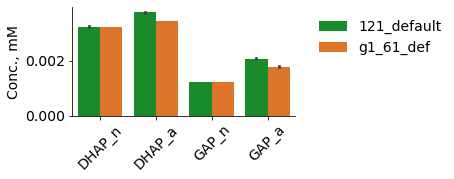

In [35]:
fig = plt.figure(figsize=(4,2))
ax = plt.subplot(111)


sns.barplot(ax=ax,
            data=input_df_mpl.loc[input_df_mpl['variable'].isin(range1)], 
            y='value', x='variable', 
            hue="condition",palette=lut_cnds,orient='v',ci=95)

ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)

ax.set_xlabel("")
ax.set_ylabel("Conc., mM")
ax.tick_params(axis='x', rotation=45)

ax.legend( bbox_to_anchor=(1.05, 1), loc='upper left',frameon=False)

plt.show()

if savefigures == True:
    
    spec_id = "bars_mets1_"
    
    fig.savefig(outpath +  spec_id +  timestr + ".pdf",transparent=False, bbox_inches="tight")
    fig.savefig(outpath +  spec_id +  timestr + ".png",dpi=300,transparent=False, bbox_inches="tight")


In [ ]:
pd.DataFrame(input_df_mpl.loc[input_df_mpl['variable'].isin(range1),['variable','condition','value']].groupby(['variable','condition'])['value'].mean())

In [ ]:
pd.DataFrame(input_df_mpl.loc[input_df_mpl['variable'].isin(range1),['variable','condition','value']].groupby(['variable','condition'])['value'].std())

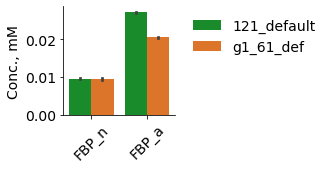

In [36]:
fig = plt.figure(figsize=(2,2))
ax = plt.subplot(111)


sns.barplot(ax=ax,
            data=input_df_mpl.loc[input_df_mpl['variable'].isin(range2)], 
            y='value', x='variable', 
            hue="condition",palette=lut_cnds,orient='v',ci=95)

ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)

ax.set_xlabel("")
ax.set_ylabel("Conc., mM")
ax.tick_params(axis='x', rotation=45)

ax.legend( bbox_to_anchor=(1.05, 1), loc='upper left',frameon=False)

plt.show()

if savefigures == True:
    
    spec_id = "bars_mets2_"
    
    fig.savefig(outpath +  spec_id +  timestr + ".pdf",transparent=False, bbox_inches="tight")
    fig.savefig(outpath +  spec_id +  timestr + ".png",dpi=300,transparent=False, bbox_inches="tight")


In [ ]:
pd.DataFrame(input_df_mpl.loc[input_df_mpl['variable'].isin(range2),['variable','condition','value']].groupby(['variable','condition'])['value'].mean())

In [ ]:
pd.DataFrame(input_df_mpl.loc[input_df_mpl['variable'].isin(range2),['variable','condition','value']].groupby(['variable','condition'])['value'].std())

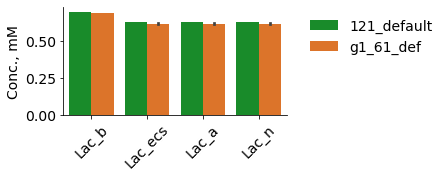

In [37]:
fig = plt.figure(figsize=(4,2))
ax = plt.subplot(111)


sns.barplot(ax=ax,
            data=input_df_mpl.loc[input_df_mpl['variable'].isin(range3)], 
            y='value', x='variable', 
            hue="condition",palette=lut_cnds,orient='v',ci=95)

ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)

ax.set_xlabel("")
ax.set_ylabel("Conc., mM")
ax.tick_params(axis='x', rotation=45)

ax.legend( bbox_to_anchor=(1.05, 1), loc='upper left',frameon=False)

plt.show()

if savefigures == True:
    
    spec_id = "bars_mets3_"
    
    fig.savefig(outpath +  spec_id +  timestr + ".pdf",transparent=False, bbox_inches="tight")
    fig.savefig(outpath +  spec_id +  timestr + ".png",dpi=300,transparent=False, bbox_inches="tight")


In [ ]:
pd.DataFrame(input_df_mpl.loc[input_df_mpl['variable'].isin(range3),['variable','condition','value']].groupby(['variable','condition'])['value'].mean())

In [ ]:
pd.DataFrame(input_df_mpl.loc[input_df_mpl['variable'].isin(range3),['variable','condition','value']].groupby(['variable','condition'])['value'].std())

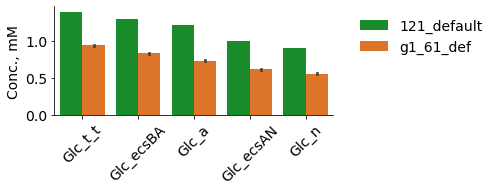

In [38]:
fig = plt.figure(figsize=(5,2))
ax = plt.subplot(111)


sns.barplot(ax=ax,
            data=input_df_mpl.loc[input_df_mpl['variable'].isin(range4)], 
            y='value', x='variable', 
            hue="condition",palette=lut_cnds,orient='v',ci=95)

ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)

ax.set_xlabel("")
ax.set_ylabel("Conc., mM")
ax.tick_params(axis='x', rotation=45)

ax.legend( bbox_to_anchor=(1.05, 1), loc='upper left',frameon=False)

plt.show()

if savefigures == True:
    
    spec_id = "bars_mets4_"
    
    fig.savefig(outpath +  spec_id +  timestr + ".pdf",transparent=False, bbox_inches="tight")
    fig.savefig(outpath +  spec_id +  timestr + ".png",dpi=300,transparent=False, bbox_inches="tight")


In [ ]:
pd.DataFrame(input_df_mpl.loc[input_df_mpl['variable'].isin(range4),['variable','condition','value']].groupby(['variable','condition'])['value'].mean())

In [ ]:
pd.DataFrame(input_df_mpl.loc[input_df_mpl['variable'].isin(range4),['variable','condition','value']].groupby(['variable','condition'])['value'].std())

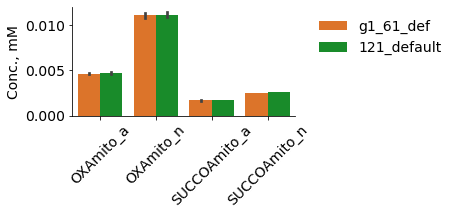

In [39]:
fig = plt.figure(figsize=(4,2))
ax = plt.subplot(111)


sns.barplot(ax=ax,
            data=input_df_mpl.loc[input_df_mpl['variable'].isin(range1j)].sort_values('variable'), 
            y='value', x='variable', 
            hue="condition",palette=lut_cnds,orient='v',ci=95)

ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)

ax.set_xlabel("")
ax.set_ylabel("Conc., mM")
ax.tick_params(axis='x', rotation=45)

ax.legend( bbox_to_anchor=(1.05, 1), loc='upper left',frameon=False)

plt.show()

if savefigures == True:
    
    spec_id = "bars_mets1j_"
    
    fig.savefig(outpath +  spec_id +  timestr + ".pdf",transparent=False, bbox_inches="tight")
    fig.savefig(outpath +  spec_id +  timestr + ".png",dpi=300,transparent=False, bbox_inches="tight")


In [ ]:
pd.DataFrame(input_df_mpl.loc[input_df_mpl['variable'].isin(range1j),['variable','condition','value']].groupby(['variable','condition'])['value'].mean())

In [ ]:
pd.DataFrame(input_df_mpl.loc[input_df_mpl['variable'].isin(range1j),['variable','condition','value']].groupby(['variable','condition'])['value'].std())

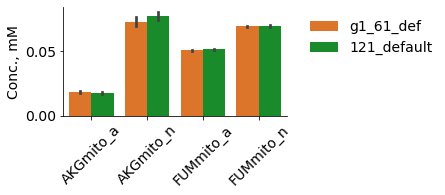

In [40]:
fig = plt.figure(figsize=(4,2))
ax = plt.subplot(111)


sns.barplot(ax=ax,
            data=input_df_mpl.loc[input_df_mpl['variable'].isin(range2j)].sort_values('variable'), 
            y='value', x='variable', 
            hue="condition",palette=lut_cnds,orient='v',ci=95)

ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)

ax.set_xlabel("")
ax.set_ylabel("Conc., mM")
ax.tick_params(axis='x', rotation=45)

ax.legend( bbox_to_anchor=(1.05, 1), loc='upper left',frameon=False)

plt.show()

if savefigures == True:
    
    spec_id = "bars_mets2j_"
    
    fig.savefig(outpath +  spec_id +  timestr + ".pdf",transparent=False, bbox_inches="tight")
    fig.savefig(outpath +  spec_id +  timestr + ".png",dpi=300,transparent=False, bbox_inches="tight")


In [ ]:
pd.DataFrame(input_df_mpl.loc[input_df_mpl['variable'].isin(range2j),['variable','condition','value']].groupby(['variable','condition'])['value'].mean())

In [ ]:
pd.DataFrame(input_df_mpl.loc[input_df_mpl['variable'].isin(range2j),['variable','condition','value']].groupby(['variable','condition'])['value'].std())

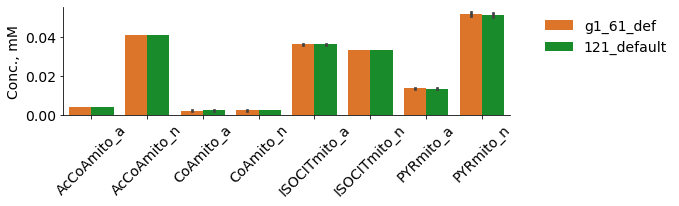

In [41]:
fig = plt.figure(figsize=(8,2))
ax = plt.subplot(111)


sns.barplot(ax=ax,
            data=input_df_mpl.loc[input_df_mpl['variable'].isin(range1a)].sort_values('variable'), 
            y='value', x='variable', 
            hue="condition",palette=lut_cnds,orient='v',ci=95)

ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)

ax.set_xlabel("")
ax.set_ylabel("Conc., mM")
ax.tick_params(axis='x', rotation=45)

ax.legend( bbox_to_anchor=(1.05, 1), loc='upper left',frameon=False)

plt.show()

if savefigures == True:
    
    spec_id = "bars_mets1a_"
    
    fig.savefig(outpath +  spec_id +  timestr + ".pdf",transparent=False, bbox_inches="tight")
    fig.savefig(outpath +  spec_id +  timestr + ".png",dpi=300,transparent=False, bbox_inches="tight")


In [ ]:
pd.DataFrame(input_df_mpl.loc[input_df_mpl['variable'].isin(range1a),['variable','condition','value']].groupby(['variable','condition'])['value'].mean())

In [ ]:
pd.DataFrame(input_df_mpl.loc[input_df_mpl['variable'].isin(range1a),['variable','condition','value']].groupby(['variable','condition'])['value'].std())

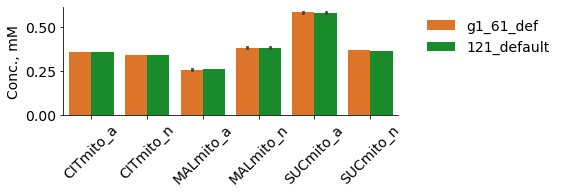

In [42]:
fig = plt.figure(figsize=(6,2))
ax = plt.subplot(111)


sns.barplot(ax=ax,
            data=input_df_mpl.loc[input_df_mpl['variable'].isin(range2a)].sort_values('variable'), 
            y='value', x='variable', 
            hue="condition",palette=lut_cnds,orient='v',ci=95)

ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)

ax.set_xlabel("")
ax.set_ylabel("Conc., mM")
ax.tick_params(axis='x', rotation=45)

ax.legend( bbox_to_anchor=(1.05, 1), loc='upper left',frameon=False)

plt.show()

if savefigures == True:
    
    spec_id = "bars_mets2a_"
    
    fig.savefig(outpath +  spec_id +  timestr + ".pdf",transparent=False, bbox_inches="tight")
    fig.savefig(outpath +  spec_id +  timestr + ".png",dpi=300,transparent=False, bbox_inches="tight")


In [ ]:
pd.DataFrame(input_df_mpl.loc[input_df_mpl['variable'].isin(range2a),['variable','condition','value']].groupby(['variable','condition'])['value'].mean())

In [ ]:
pd.DataFrame(input_df_mpl.loc[input_df_mpl['variable'].isin(range2a),['variable','condition','value']].groupby(['variable','condition'])['value'].std())